In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ml_metrics import quadratic_weighted_kappa
import xgboost as xgb
import datetime as dt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import functools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from scipy import optimize

from xgboostmodel import XGBoostModel, ModelPrediction

# Step 04.  Drop features

In this step we will use the results from a ridge regression performed separately in R.  We will drop the features with the least significant linear coefficients.  The dropping cutoff will be determined by a quantile in the distrubution of feature coefficients, as shown below:

number of features to drop =  73
['BMI' 'Employment_Info_2' 'Employment_Info_3' 'Employment_Info_4'
 'Employment_Info_6' 'Family_Hist_1' 'Id' 'Ins_Age' 'Insurance_History_1'
 'Insurance_History_2' 'Insurance_History_3' 'InsuredInfo_1'
 'InsuredInfo_2' 'InsuredInfo_3' 'InsuredInfo_4' 'InsuredInfo_5'
 'InsuredInfo_7' 'Medical_History_12' 'Medical_History_16'
 'Medical_History_18' 'Medical_History_19' 'Medical_History_28'
 'Medical_History_30' 'Medical_History_34' 'Medical_History_35'
 'Medical_History_36' 'Medical_History_38' 'Medical_History_5'
 'Medical_History_8' 'Medical_History_9' 'Medical_Keyword_1'
 'Medical_Keyword_10' 'Medical_Keyword_13' 'Medical_Keyword_14'
 'Medical_Keyword_17' 'Medical_Keyword_18' 'Medical_Keyword_21'
 'Medical_Keyword_23' 'Medical_Keyword_24' 'Medical_Keyword_28'
 'Medical_Keyword_3' 'Medical_Keyword_31' 'Medical_Keyword_32'
 'Medical_Keyword_36' 'Medical_Keyword_37' 'Medical_Keyword_38'
 'Medical_Keyword_4' 'Medical_Keyword_42' 'Medical_Keyword_43'
 'Medic

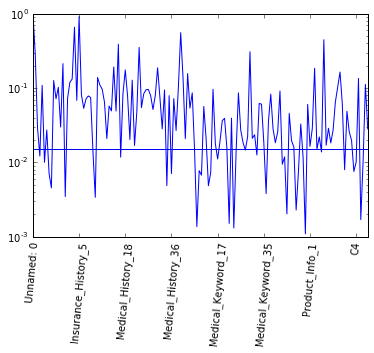

In [2]:
feature_quantile_cut = 0.5

ridge_coefs = pd.read_csv('csvs/R_ridge_coefficients.csv').iloc[0]
cut = ridge_coefs.quantile(feature_quantile_cut)

to_drop = ridge_coefs[ridge_coefs < cut].index.values

ax = ridge_coefs.abs().plot()
for tick in ax.get_xticklabels():
    tick.set_rotation(85)
ax.axhline(cut)
ax.set_yscale('log')

print("number of features to drop = ", len(to_drop))
print(to_drop)

We start out by fitting our best `reg:linear` and `multi:softmax` models which we obtained in Step 02:

In [3]:
booster = XGBoostModel(nfolds=3)

fold = 1 # the fold to use for train-test split

# Iterate over possible cutoffs for feature selection.  
# A larger value of fqc results in fewer features. 
for fqc in [0.2, 0.4, 0.5, 0.6, 0.7, 0.8]:
    booster.learn_model(fold, objective='reg:linear', num_round=250, 
                        feature_quantile_cut = fqc,
                        make_plot=False,
                        eta=0.06,
                        max_depth=9,
                        min_child_weight=150,
                        colsample_bytree=0.8,
                        subsample=0.8)

In [5]:
for fqc in [0.05, 0.10, 0.15]:
    booster.learn_model(fold, objective='reg:linear', num_round=250, 
                        feature_quantile_cut = fqc,
                        make_plot=False,
                        eta=0.06,
                        max_depth=9,
                        min_child_weight=150,
                        colsample_bytree=0.8,
                        subsample=0.8)

In [7]:
booster.learn_model(fold, objective='reg:linear', num_round=500, 
                    feature_quantile_cut = 0.5,
                    make_plot=False,
                    eta=0.06,
                    max_depth=9,
                    min_child_weight=150,
                    colsample_bytree=0.8,
                    subsample=0.8)

In [9]:
booster.learn_model(fold, objective='reg:linear', num_round=500, 
                    feature_quantile_cut = 0.0,
                    make_plot=False,
                    eta=0.06,
                    max_depth=9,
                    min_child_weight=150,
                    colsample_bytree=0.8,
                    subsample=0.8)

In [12]:
booster.get_scores()[['objective', 'feature_quantile_cut', 'num_round', 'train_qwk', 'test_qwk']].sort_values(
    by='feature_quantile_cut')

,objective,feature_quantile_cut,num_round,train_qwk,test_qwk
10,reg:linear,0.00,500,0.719088,0.604730
6,reg:linear,0.05,250,0.587842,0.507359
7,reg:linear,0.10,250,0.581581,0.491690
8,reg:linear,0.15,250,0.567539,0.482155
0,reg:linear,0.20,250,0.568164,0.480148
1,reg:linear,0.40,250,0.561246,0.475550
2,reg:linear,0.50,250,0.555578,0.477683
9,reg:linear,0.50,500,0.600638,0.477453
3,reg:linear,0.60,250,0.545567,0.469928
4,reg:linear,0.70,250,0.534987,0.465565


## We see immediately that dropping features does not improve the xgboost model much at all, in fact it is very detrimental.  Next on we will explore the possibility of adding custom features. 